In [1]:
# add simpegseisc directory to path
import os
if '..' not in os.sys.path:
    os.sys.path.append('..')

In [2]:
from simpegseis import *
%pylab inline
from SimPEG.Utils import mkvc

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
# Step1: set time
dt = 6e-5
ntime = 2000
time = np.arange(ntime)*dt
# Step4: set mesh
cs = 0.20
cs = 0.20
hx = np.ones(500.)*cs
hy = np.ones(250.)*cs
mesh = Mesh.TensorMesh([hx, hy], 'CC')
# Step2: set Tx and Rx
tlag = 0.008
fmain = 100.
options={'tlag':1./fmain, 'fmain':fmain} # You need to set waveform to set Tx
nrx = 180
xtemp_rx = np.arange(nrx)*0.5+0.5+mesh.vectorCCx.min()
xy_rx = np.c_[xtemp_rx, np.ones(nrx)*mesh.vectorCCy.max()]
rx = AcousticRx(xy_rx)

tx = AcousticSrc(np.r_[mesh.vectorCCx.min(), mesh.vectorCCy.max()], time, [rx], **options)
# Step3: set survey (pass txlist)
survey = SurveyAcoustic([tx])
wave = tx.RickerWavelet()
# Step5: set problem (pass mesh) and pair with survey
prob = AcousticProblemPML(mesh)
prob.pair(survey)
# Step6: set boundary
prob.setPMLBC(20, dt, bcflag='left', const=1.)
prob.storefield = True
# Step7: set velocity model and check stability
v = np.ones(mesh.nC)*400.
v[mesh.gridCC[:,1]<mesh.vectorCCy.max()-5.] = 1000.
v[mesh.gridCC[:,1]<mesh.vectorCCy.max()-15.] = 1500.
prob.stabilitycheck(v, time, 100.)

You are good to go:)
>> Stability information
   dt: 6.00e-05 s
   Optimal dt: 6.67e-05 s
   Cell per wavelength (G): 2.00e+01
   Optimal G: 1.60e+01


/home/isisilon/.virtualenvs/main/local/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


0.11994


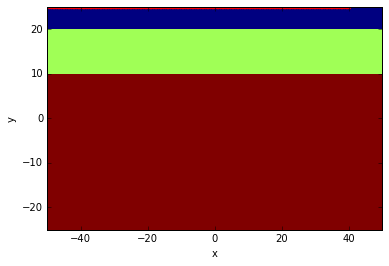

In [4]:
print time.max()
mesh.plotImage(v)
plt.plot(rx.locs[:,0], rx.locs[:,1], 'r.')

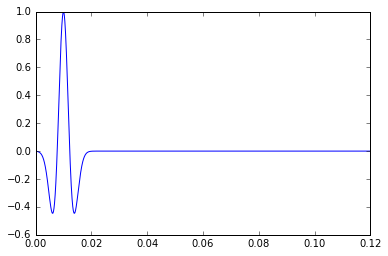

In [5]:
plt.plot(time, wave)

In [6]:
# Step8: run forward
U = prob.fields(v)

>> Start Computing Acoustic Wave
>> dt: 6.00e-05 s
>> Optimal dt: 6.67e-05 s
>> Main frequency, fmain: 1.00e+02 Hz
>> Cell per wavelength (G): 2.00e+01
  Src at ( -49.90,  -49.90):    1/   1
>>Elapsed time: 5.47e+01 s


In [7]:
# Step9: project data
data = survey.projectFields(U)

In [8]:
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')
# matplotlib.rcParams['savefig.dpi'] = 200 # Change this to adjust figure size

../simpegseis/UtilsSeis.py:48: RuntimeWarning: divide by zero encountered in divide
  time = np.sqrt(x**2/velocity**2+tinterp**2)


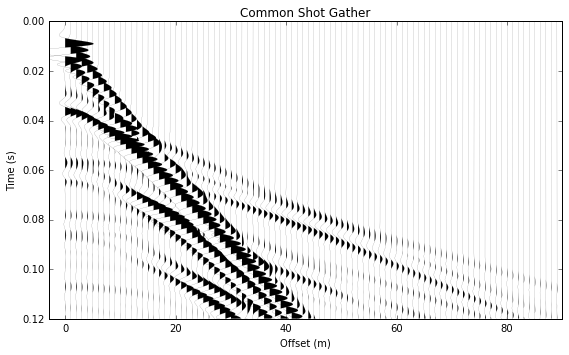

In [10]:
fig = plt.figure()
kwargs = {
    'skipt': 2,
    'scale': 0.05,
    'lwidth': 0.1,
    'sampr': dt,
    'dx':0.5
}
extent = [-3, 90, 0.12, 0]
fig, ax1 = plt.subplots(1,1, figsize = (8,5))
ax1.invert_yaxis()
ax1.axis(extent)
UtilsSeis.wiggle(data[0], **kwargs)
ax1.plot(UtilsSeis.PrimaryWave(7e-3, time, 400.), time, 'k-', lw=2)
ax1.plot(UtilsSeis.ReflectedWave(7e-3, time, 400.), time, 'b-', lw=2)
ax1.plot(UtilsSeis.PrimaryWave(0.032, time, 1000.), time, 'r-', lw=2)
ax1.plot(UtilsSeis.PrimaryWave(0.048, time, 1500.), time, 'g-', lw=2)

ax1.set_xlabel('Offset (m)')
ax1.set_ylabel('Time (s)')
ax1.set_title('Common Shot Gather')
fig.tight_layout()
fig.savefig("model1_data_with_lines", dpi = 200)

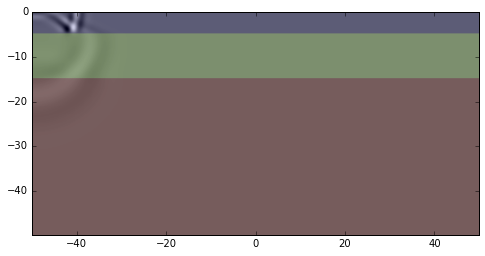

In [11]:
icount = 600
fig, ax = plt.subplots(1,1, figsize = (8, 5))
extent = [mesh.vectorCCx.min(), mesh.vectorCCx.max(), mesh.vectorCCy.min()-mesh.vectorCCy.max(), mesh.vectorCCy.max()-mesh.vectorCCy.max()]
ax.imshow(np.flipud(U[0][:,icount].reshape((mesh.nCx, mesh.nCy), order = 'F').T), cmap = 'binary', extent=extent)  
ax.imshow(np.flipud(v.reshape((mesh.nCx, mesh.nCy), order = 'F').T), cmap = 'jet', extent=extent, alpha = 0.2)  

In [12]:
print data[0].shape

(180, 2000)



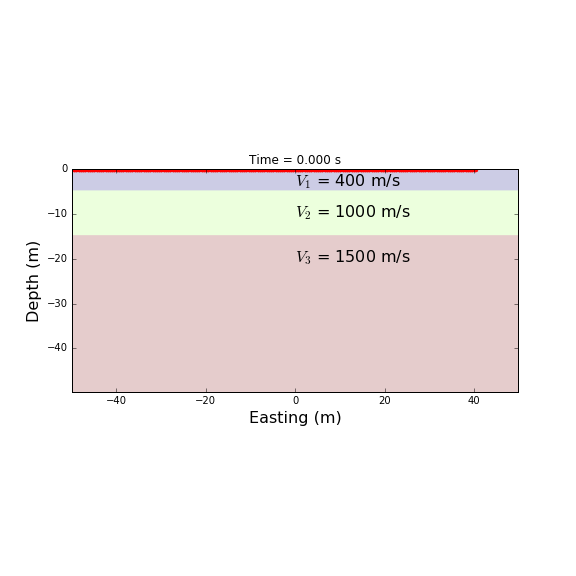
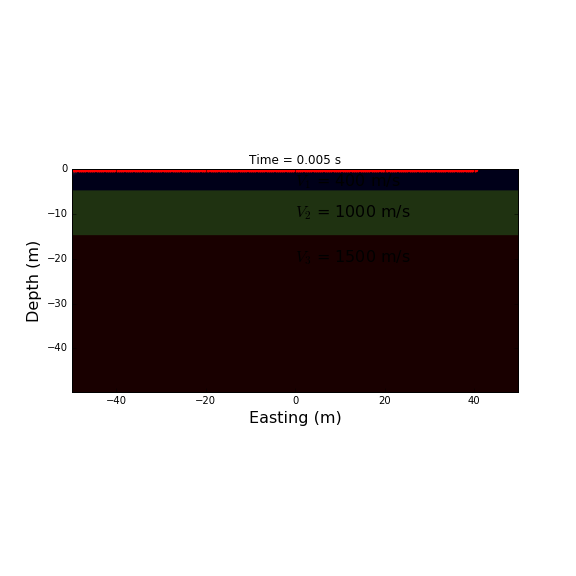
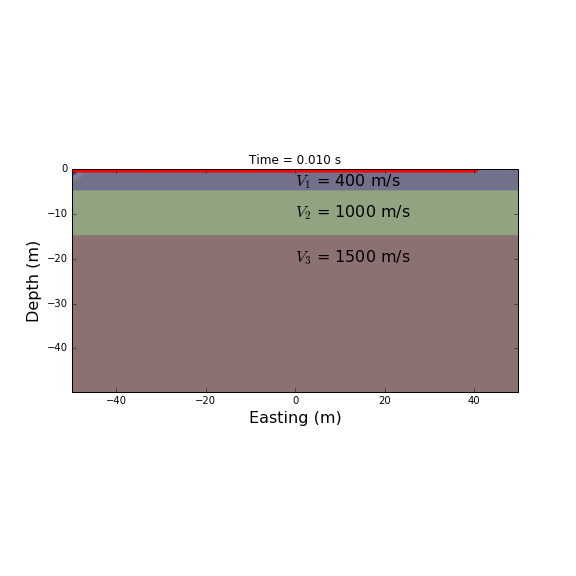
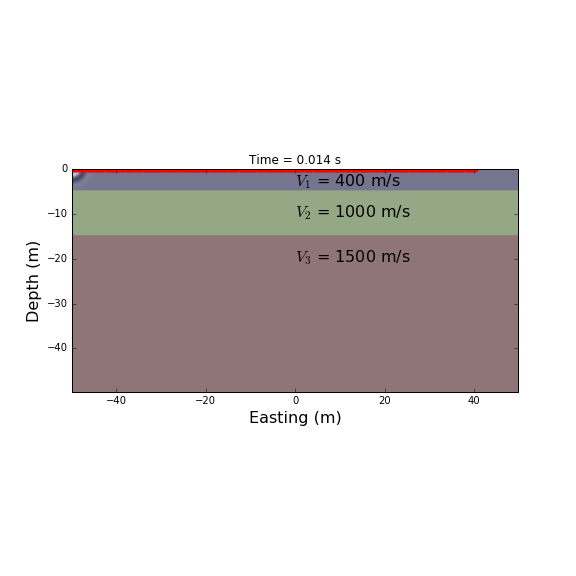
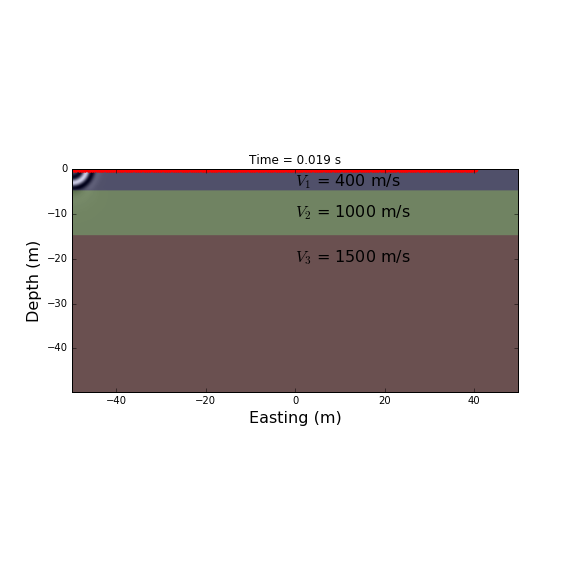
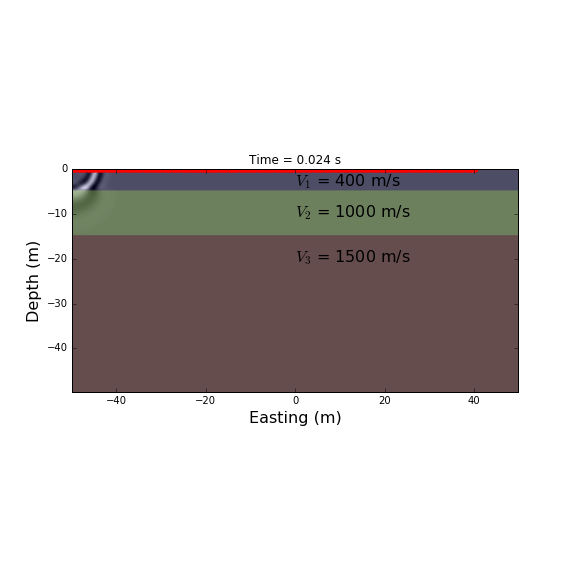
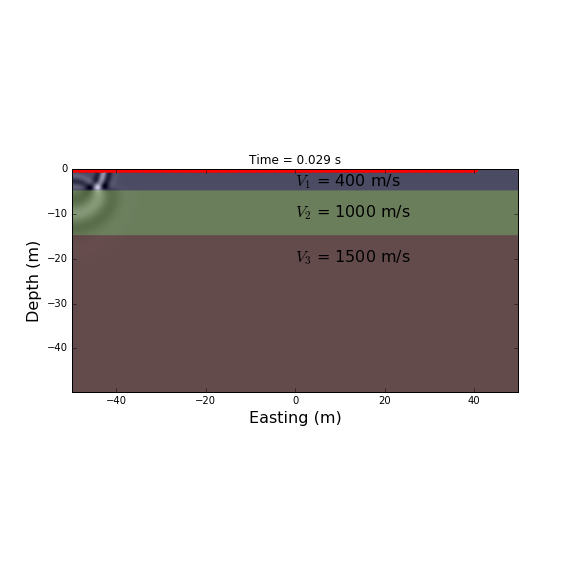
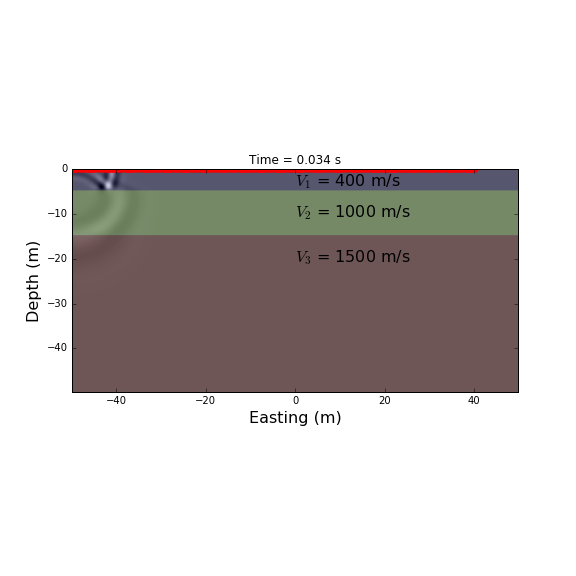
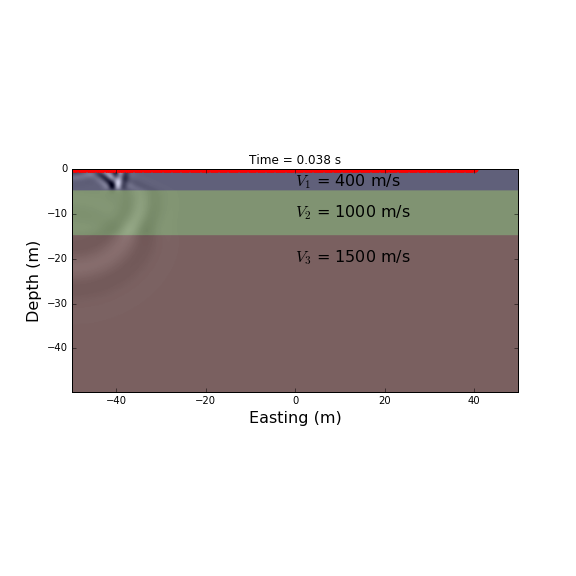
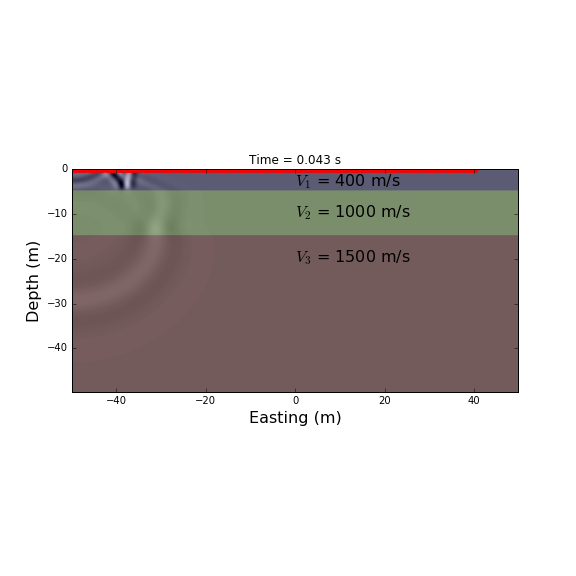
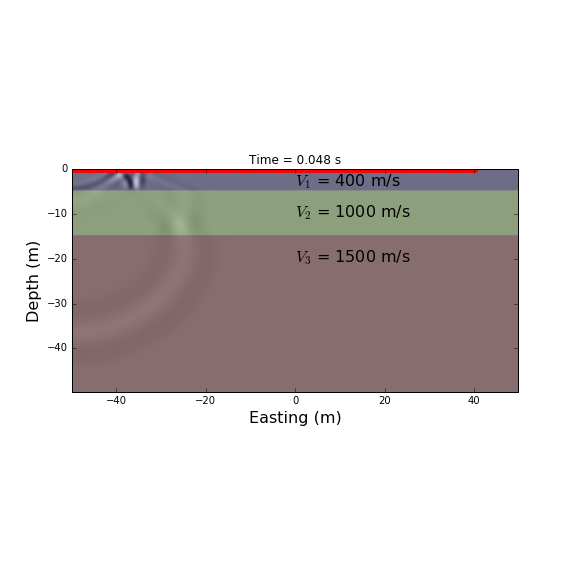
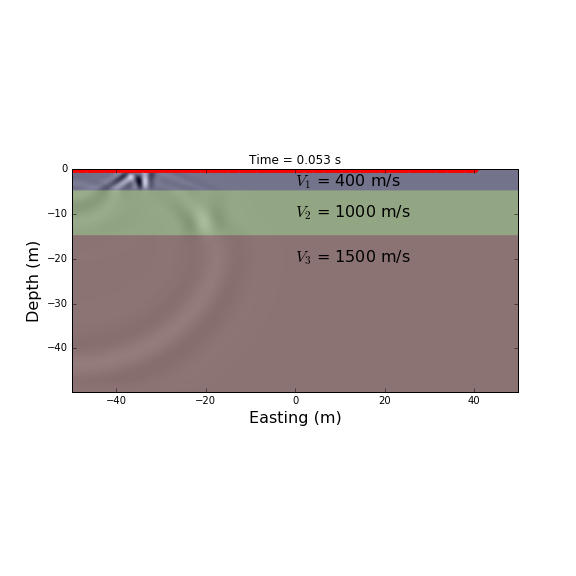
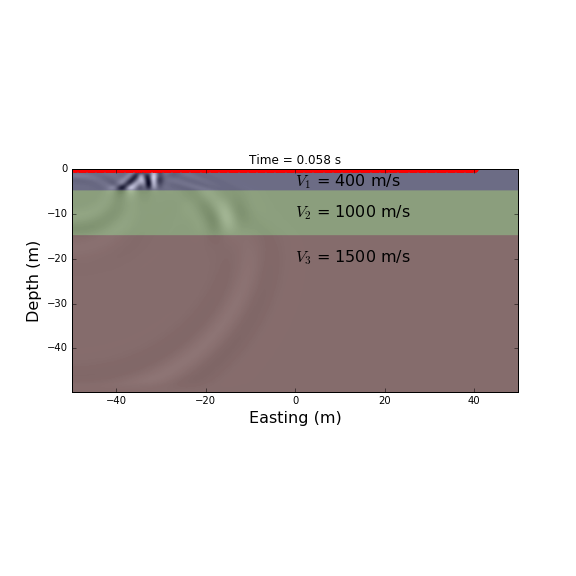
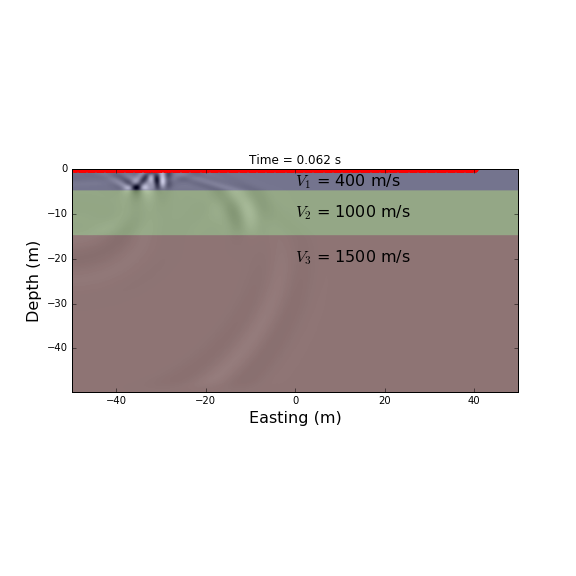
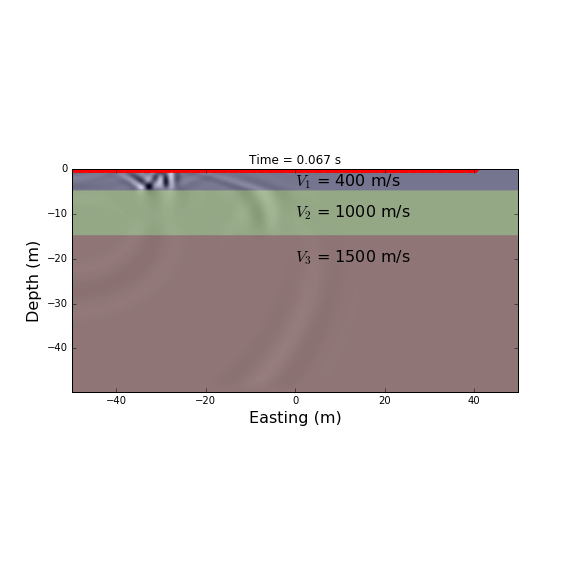
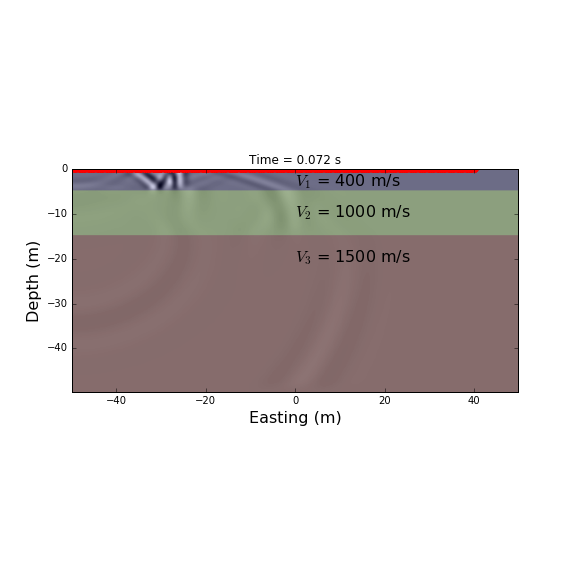
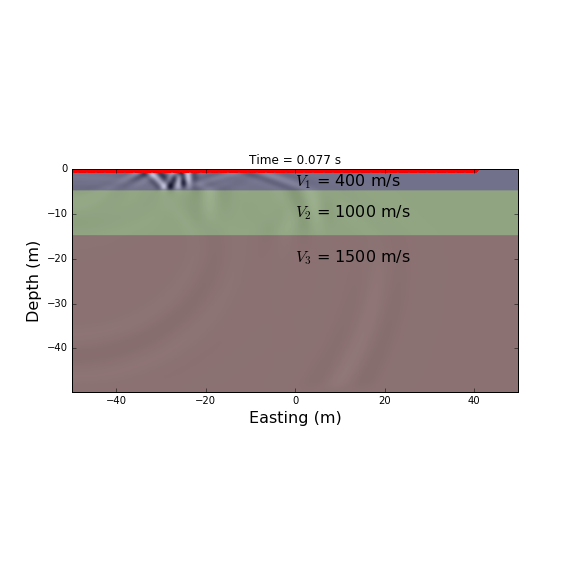
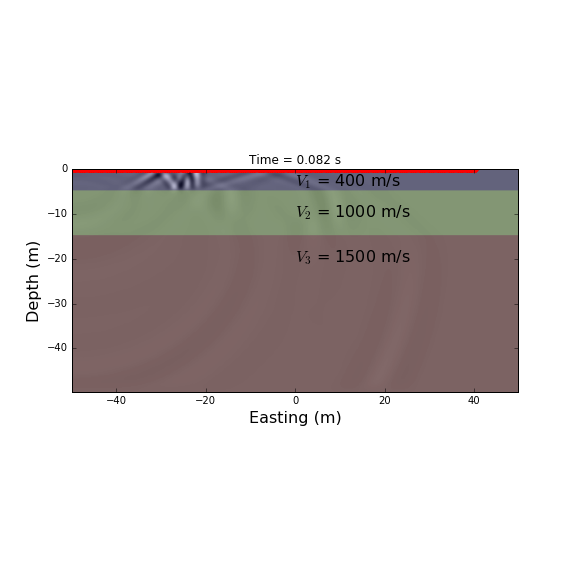
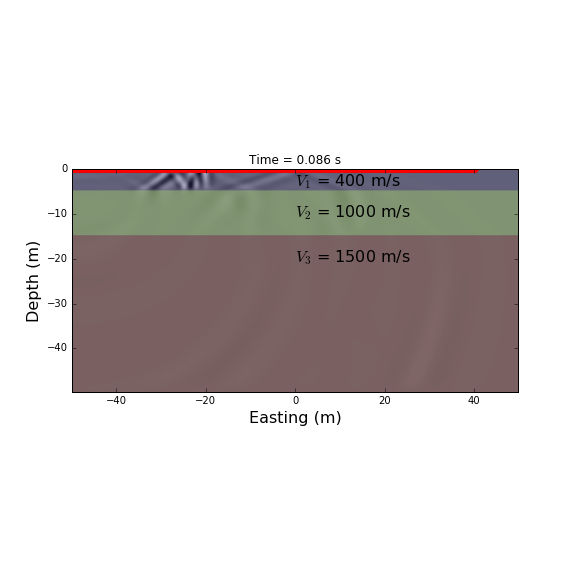
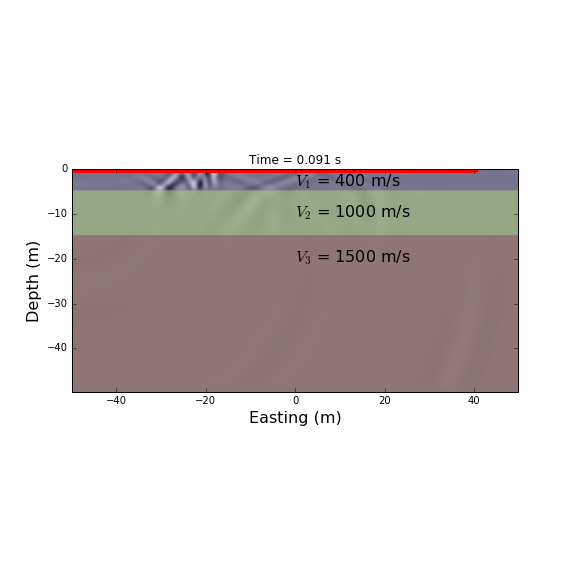
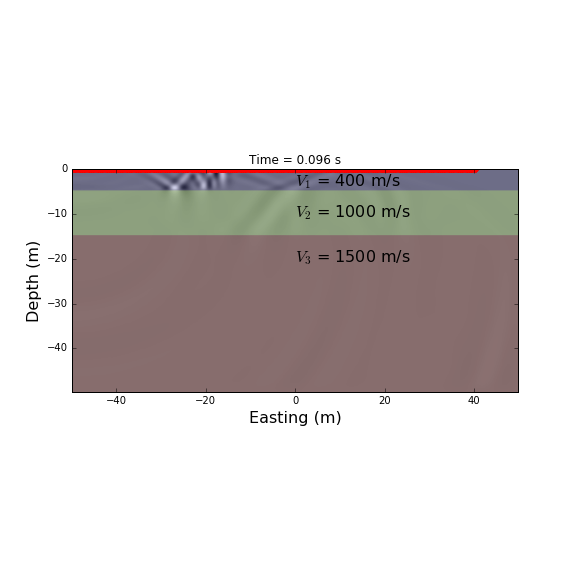
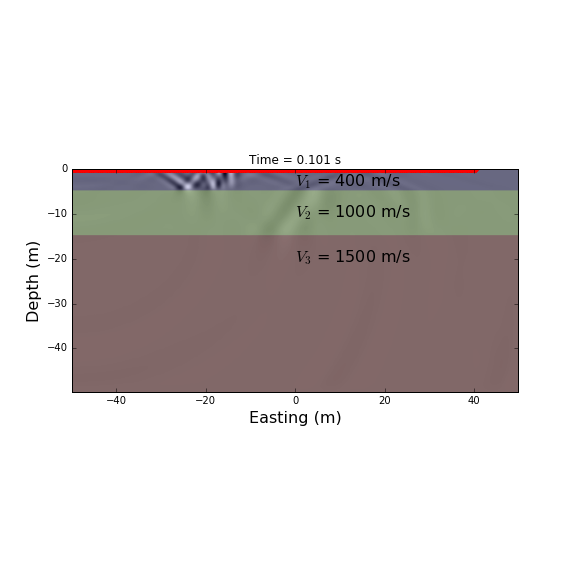
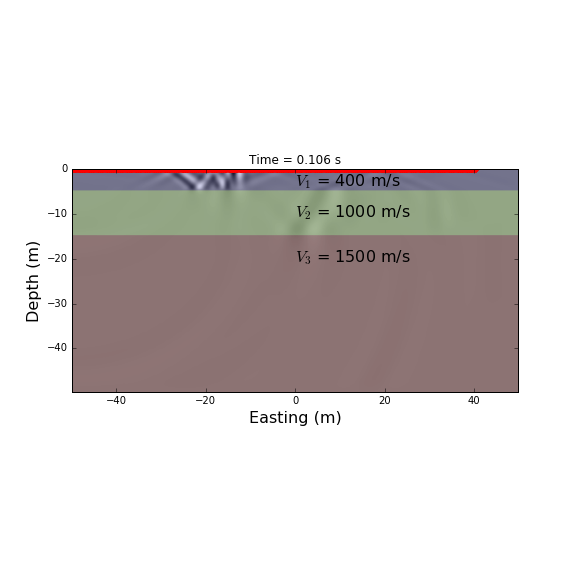
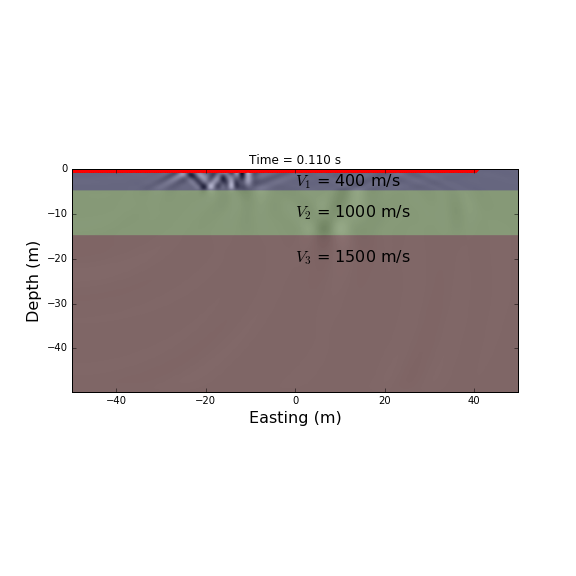
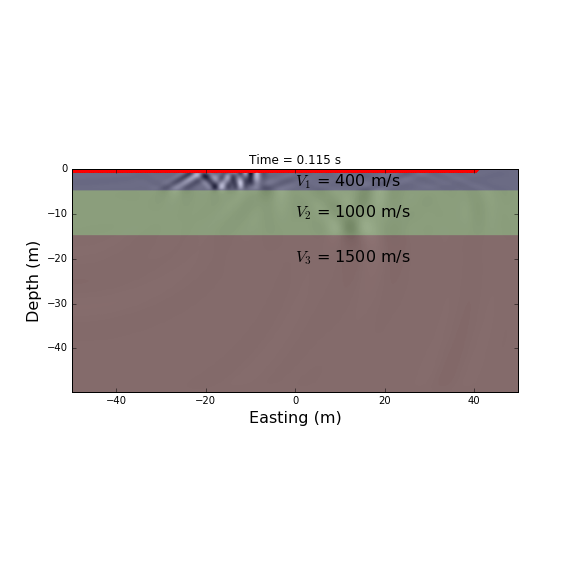

In [17]:
from JSAnimation import IPython_display
from matplotlib import animation
fig, ax = plt.subplots(1,1, figsize = (8, 8))
ax.set_xlabel('Easting (m)', fontsize = 16)
ax.set_ylabel('Depth (m)', fontsize = 16)
extent = [mesh.vectorCCx.min(), mesh.vectorCCx.max(), mesh.vectorCCy.min()-mesh.vectorCCy.max(), mesh.vectorCCy.max()-mesh.vectorCCy.max()]
ax.set_xlim(extent[:2])
ax.set_ylim(extent[2:])
ax.text(0, -3.8, '$V_1$ = 400 m/s', fontsize = 16)
ax.text(0, -10.8, '$V_2$ = 1000 m/s', fontsize = 16)
ax.text(0, -20.8, '$V_3$ = 1500 m/s', fontsize = 16)
nskip = 80
def animate(i_id):
    icount = i_id*nskip
    frame = ax.imshow(np.flipud(U[0][:,icount].reshape((mesh.nCx, mesh.nCy), order = 'F').T), cmap = 'binary', extent=extent)    
    ax.imshow(np.flipud(v.reshape((mesh.nCx, mesh.nCy), order = 'F').T), cmap = 'jet', extent=extent, alpha = 0.2)  
    ax.plot(rx.locs[:,0], rx.locs[:,1]-mesh.vectorCCy.max(), 'r.', ms = 10)
    ax.set_title(('Time = %5.3f s')%(time[i_id*nskip]))
    
    return frame
animation.FuncAnimation(fig, animate, frames=25, interval=40, blit=False)